In [1]:
import sys
import os
import ssm
import itertools
import pickle 

import autograd.numpy          as np
import pandas                  as pd

import matplotlib.pyplot       as plt
import seaborn                 as sns
from   matplotlib.ticker       import FuncFormatter


from   sklearn.model_selection import KFold
from   sklearn.mixture         import GaussianMixture

sns.set_style("white")
#sns.set_context("talk")

## Autoregressive Hidden Markov Models for modelling baby movement
Using the [ssm](https://github.com/lindermanlab/ssm) package.  

### Aims
- Fit (AR)HMM models to pre-processed movement data  
- Compare model fit when including autoregressive terms in observations  
- Use cross-validation to determine number of hidden states and lag

Using Hidden Markov Models (HMM), a continuous, $D$-dimension $\times$ $t$-timestep timeseries, $X$, can be modelled as a Markov process, $Z$, with a set of $K$ hidden states, {$z_1$, $z_2$, $...$, $z_k$}, that are not directly observable. Each state is associated with a $D$-dimensional mean $\mu_k$ and $D \times D$ covariance matrix $S_k$ from which the multivariate observations are drawn at each time step. The hidden states are assumed to progress as a Markov process, where the next state is dependent only on the current state: $p(z_t | z_{t-1})$. Switches between states are governed by a $K \times K$ transition matrix, $T$ containing state transition probabilities, $\phi$, where $\phi_{zz'}$ indicates the probability of transitioning from state $z$ at time $t$ to state $z'$ at time $t+1$. As any given state is only dependent on the previous state, HMMs do not capture autocorrelations in timeseries data.

In an AutoRegressive HMM (ARHMM), the observations, $x_t$ at time $t$ are dependent on $both$ the hidden state, $z_t$, and the observations at previous timespoints, {$x_{t-1}$, $x_{t-2}$, $...$, $x_{t-n}$} with $n$ determined by the degree of lag specified. As such the observation model for a given state, $z_k$, is defined as:

$$ x_t | x_{t-1:L}, z_k \sim N(\sum_{l=1}^LA_k^{(l)}x_{t-l}+b_k,S_k)$$   

.... i think this is the right formulation for multiple lags...

where $x_t$ is a set of observations at time $t$, $A_k^{(l)}$ is a matrix containing the linear dynamics for the given state (the relationship between observations at time $t$ and at a given lag, $l$), $b_k$ is a state-dependent bias (average value of each variable in each state) and $S_k$ is a state-dependent covariance function, modelling observation noise.

<img src="graphical_model.png" width="500"/>




### Parameters

In [2]:
CV = 5 # number of cross-validation folds
ITER = 200
TOL = 1e-2

# ARHMM
ARHMM_OBS = ['ar']
ARHMM_K = [1, 2, 5, 8, 10, 15, 20, 25] #k=1 is standard AR
ARHMM_LAGS = [1, 2]
ARHMM_PARAMS = list(itertools.product(ARHMM_OBS, ARHMM_K, ARHMM_LAGS))

# HMM (no autoregression)
HMM_OBS = ['gaussian']
HMM_K = [1, 2, 5, 8, 10, 15, 20, 25]
HMM_PARAMS = list(itertools.product(HMM_OBS, HMM_K))

ALL_HMM_PARAMS =  ARHMM_PARAMS + HMM_PARAMS

# GMM (no state progression)
GMM_OBS = ['full']
GMM_K = [1, 2, 5, 8, 10, 15, 20, 25]

GMM_PARAMS = list(itertools.product(GMM_OBS, GMM_K))

RAND_STATE = 1001

### Load preprocessed data

Data represents a $subject \times feature \times timepoint$ array. Where $features$ are the framewise velocities (first derivative) of principal movements extracted from keypoint trajectory data. Subect data are split into cross-validation folds, ensuring no subject has video in both test and train in any given fold.

In [3]:
data = np.load('outputs/random_subset_processed_timeseries_data.npy')
info = pd.read_csv('outputs/random_subset_info.csv')
os.makedirs('outputs/cv-samples', exist_ok=True)

print('data shape: ', np.shape(data))
num_vids, num_features, num_timepoints = data.shape

#train test 
# split on participant (not video) to ensure that same subject data are not in both train and test
unique_participants = info.drop_duplicates(subset = 'idnum', keep = 'first')
X = unique_participants['idnum'].values

# get splits
kf = KFold(n_splits=CV, shuffle=True, random_state=RAND_STATE).split(X)

# get participant train and test ids for each fold
kfold_idx = [(X[train_idx], X[test_idx]) for train_idx, test_idx in kf]

# get index in 'info' and 'data' for entries that match the unique participant id
kfold_idx = [(np.where(info['idnum'].isin(trainidx))[0], np.where(info['idnum'].isin(testidx))[0])  for trainidx, testidx in kfold_idx]

# check there are no participants in both train and test in a given fold
for k in np.arange(CV):
    assert len(set(info.iloc[kfold_idx[k][0]].participant.unique()) & set(info.iloc[kfold_idx[k][1]].participant.unique())) == 0

data shape:  (100, 15, 1800)


### Run cross-validation
HMMs for each parameter set are run in a k-fold cross-valisation with per-observation average log likelihood in both train and test data and AIC as a measure of model fit. The score reflect the likelihood that a given $D$-dimensional observation could have been generated by a given model. We compare ARHMM at different lags and with different states with standard HMM (no autocorrelation) over a number of states and Gaussian Mixture Models (stationary model where observations are simply drawn from separate distributions and we do not model state progression). 

Models are trained for a maximum of 200 Expectation-Maximisation iterations, stopping early if change in log-likelihood is less than 0.01


In [ ]:
# space for results
hmm_results = np.zeros((len(ALL_HMM_PARAMS), 8, CV)) # model x train/test scores x folds
gmm_results = np.zeros((len(GMM_PARAMS), 8, CV)) # model x train/test scores x folds

# transformer
for f, (train_idx, test_idx) in enumerate(kfold_idx):
    print('FOLD {:}----------------------------------------------'.format(f+1))
    train_data = np.array([data[i,:,:].T for i in train_idx])
    test_data = np.array([data[i,:,:].T for i in test_idx])
    
    # standardise PC weights
    train_data_scaled = (train_data - np.mean(train_data, axis=1)[:,np.newaxis,:]) / np.std(train_data, axis=1)[:, np.newaxis, :]
    test_data_scaled = (test_data - np.mean(test_data, axis=1)[:,np.newaxis,:]) / np.std(test_data, axis=1)[:, np.newaxis, :]
    
    # take first difference
    train_data_diff = np.diff(train_data_scaled, n=1, axis=1)
    test_data_diff = np.diff(test_data_scaled, n=1, axis=1)

    #time_series = time_series - np.mean(time_series, axis=1)[:,np.newaxis,:]
    # global normalise
    train_data_diff = train_data_diff / np.std(train_data_diff, axis=(1,2))[:, np.newaxis, np.newaxis]
    train_data_diff = [train_data_diff[i] for i in np.arange(len(train_data_diff))]
    test_data_diff = test_data_diff / np.std(test_data_diff, axis=(1,2))[:, np.newaxis, np.newaxis]
    test_data_diff = [test_data_diff[i] for i in np.arange(len(test_data_diff))]

    fig, axs = plt.subplots(5, 1, figsize=(5,8), sharex=True)
    for n,ax in enumerate(axs):
        sns.lineplot(np.arange(num_features)+train_data_diff[n], lw=.5, dashes=False, ax=ax, legend=False, palette='husl')
        ax.set_ylim(-5,25)
    axs[0].set_title('data samples')
    sns.despine(left=True, bottom=True)
    plt.tight_layout()
    plt.savefig('outputs/cv-samples/data-samples-fold{:}.png'.format(f), transparent=False, dpi=300)
    plt.close()

    # parse model parameters
    kappa = num_vids * num_timepoints
    for n_p, p_set in enumerate(ALL_HMM_PARAMS):
        if len(p_set)==3:
            obs, k, lag = [*p_set]
            model = ssm.HMM(k, num_features, 
                            init_method='kmeans',
                            observations=obs, observation_kwargs={'lags':lag}, 
                            transitions='standard',# transition_kwargs={'kappa': kappa},
                            method='stochastic_em')
            
            print('fitting {:} model with k={:} and lags={:}'.format(obs, k, lag))
            
        else:
            assert(len(p_set)==2), 'check HMM params'
            obs, k = [*p_set]
            lag = None
            model = ssm.HMM(k, num_features, 
                            init_method='kmeans',
                            observations=obs, 
                            transitions='standard', #transition_kwargs={'kappa': kappa},
                            method='stochastic_em')
            
            print('fitting {:} model with k={:}'.format(obs, k))
        
        # model fit
        lls = model.fit(train_data_diff, num_iters=ITER, tolerance=TOL)

        # record scores
        nparams = sum([np.size(i) for i in model.params[-1]] + [np.size(i) for i in model.params[:-1]])
        train_eff_n = len(train_data_diff) * len(train_data_diff[0])              
        train_score = model.log_likelihood(train_data_diff)    
                       
        train_av_score = train_score / train_eff_n
        train_aic = (-2 * train_score) + (2 * nparams)              
        train_bic = (-2 * train_score) + nparams * np.log(train_eff_n)
              
        test_eff_n = len(test_data_diff) * len(test_data_diff[0])              
        test_score = model.log_likelihood(test_data_diff)
        
        test_av_score = test_score / test_eff_n
        test_aic = (-2 * test_score) + (2 * nparams)              
        test_bic = (-2 * test_score) + nparams * np.log(test_eff_n)
                
        print('training LL: {:.2f}  training AIC: {:.2f}  training BIC: {:.2f}  testing LL: {:.2f}  testing AIC {:.2f}  testing BIC: {:.2f}'.format(train_av_score, train_aic, train_bic, test_av_score, test_aic, test_bic))
        print('sample mean rle: {:.2f}'.format(np.mean(ssm.util.rle(model.most_likely_states(train_data_diff[0]))[1]) * .1))
        print('')
        print('-----------------------------------------------')

        # store
        hmm_results[n_p, 0, f] = train_score
        hmm_results[n_p, 1, f] = train_av_score
        hmm_results[n_p, 2, f] = train_aic
        hmm_results[n_p, 3, f] = train_bic

        hmm_results[n_p, 4, f] = test_score
        hmm_results[n_p, 5, f] = test_av_score
        hmm_results[n_p, 6, f] = test_aic
        hmm_results[n_p, 7, f] = test_bic

        fig, axs = plt.subplots(5, 1, figsize=(5,8), sharex=True)
        for ax in axs:
            sns.lineplot(np.arange(num_features)+model.sample(num_timepoints+1000)[1][1000:], lw=.5, dashes=False, ax=ax, legend=False, palette='husl')
            ax.set_ylim(-5,25)
        axs[0].set_title('model samples')
        sns.despine(left=True, bottom=True)
        plt.tight_layout()
        if lag is not None:
            plt.savefig('outputs/cv-samples/HMMmodel-samples-{:}-k{:}-lag{:}-fold{:}.png'.format(obs, k, lag, f), transparent=False, dpi=300)
        else:
            plt.savefig('outputs/cv-samples/HMMmodel-samples-{:}-k{:}-fold{:}.png'.format(obs, k, f), transparent=False, dpi=300)
        plt.close()
        
        
    for n_p, p_set in enumerate(GMM_PARAMS):
        obs, k = [*p_set]
        
        concat_data = np.concatenate(train_data_diff)
        
        model = GaussianMixture(n_components=k, covariance_type=obs, max_iter=ITER, tol=TOL)
        model.fit(concat_data)
        
        train_av_score = model.score(concat_data)
        train_score = train_av_score * len(concat_data)
        train_aic = model.aic(concat_data)
        train_bic = model.bic(concat_data)

        test_av_score = model.score(np.concatenate(test_data_diff))
        test_score = test_score * len(np.concatenate(test_data_diff))
        test_aic = model.aic(np.concatenate(test_data_diff))
        test_bic = model.bic(np.concatenate(test_data_diff))
        
        print('fitting gaussian mixture model with k={:}'.format(k))
        print('training LL: {:.2f}  training AIC: {:.2f}  training BIC: {:.2f}  testing LL: {:.2f}  testing AIC {:.2f}  testing BIC: {:.2f}'.format(train_av_score, train_aic, train_bic, test_av_score, test_aic, test_bic))
        print('')
        print('-----------------------------------------------')

        # store
        gmm_results[n_p, 0, f] = train_score
        gmm_results[n_p, 1, f] = train_av_score
        gmm_results[n_p, 2, f] = train_aic
        gmm_results[n_p, 3, f] = train_bic

        gmm_results[n_p, 4, f] = test_score
        gmm_results[n_p, 5, f] = test_av_score
        gmm_results[n_p, 6, f] = test_aic
        gmm_results[n_p, 7, f] = test_bic

        fig, axs = plt.subplots(5, 1, figsize=(5,8), sharex=True)
        for ax in axs:
            sns.lineplot(np.arange(num_features)+model.sample(num_timepoints+1000)[0][1000:], lw=.5, dashes=False, ax=ax, legend=False, palette='husl')
            ax.set_ylim(-5,25)
        axs[0].set_title('model samples')
        sns.despine(left=True, bottom=True)
        plt.tight_layout()
        plt.savefig('outputs/cv-samples/MMmodel-samples-{:}-k{:}-fold{:}.png'.format(obs, k, f), transparent=False)
        plt.close()
        

FOLD 1----------------------------------------------
fitting ar model with k=1 and lags=1


  0%|          | 0/200 [00:00<?, ?it/s]

training LL: -19.85  training AIC: 5571175.59  training BIC: 5575776.33  testing LL: -19.89  testing AIC 1575082.19  testing BIC: 1579091.86
sample mean rle: 179.90

-----------------------------------------------
fitting ar model with k=1 and lags=2


  0%|          | 0/200 [00:00<?, ?it/s]

training LL: -19.34  training AIC: 5427919.99  training BIC: 5434737.37  testing LL: -19.27  testing AIC 1526954.59  testing BIC: 1532896.12
sample mean rle: 179.90

-----------------------------------------------
fitting ar model with k=2 and lags=1


  0%|          | 0/200 [00:00<?, ?it/s]

training LL: -16.96  training AIC: 4762094.94  training BIC: 4771316.12  testing LL: -17.09  testing AIC 1354863.22  testing BIC: 1362899.74
sample mean rle: 0.47

-----------------------------------------------
fitting ar model with k=2 and lags=2


  0%|          | 0/200 [00:00<?, ?it/s]

training LL: -16.52  training AIC: 4639911.25  training BIC: 4653565.70  testing LL: -16.57  testing AIC 1314363.33  testing BIC: 1326263.56
sample mean rle: 0.46

-----------------------------------------------
fitting ar model with k=5 and lags=1


  0%|          | 0/200 [00:00<?, ?it/s]

training LL: -15.61  training AIC: 4384698.06  training BIC: 4407898.81  testing LL: -15.75  testing AIC 1251201.66  testing BIC: 1271421.76
sample mean rle: 0.27

-----------------------------------------------
fitting ar model with k=5 and lags=2


  0%|          | 0/200 [00:00<?, ?it/s]

training LL: -15.19  training AIC: 4269566.46  training BIC: 4303850.36  testing LL: -15.25  testing AIC 1214333.90  testing BIC: 1244213.28
sample mean rle: 0.28

-----------------------------------------------
fitting ar model with k=8 and lags=1


  0%|          | 0/200 [00:00<?, ?it/s]

training LL: -15.24  training AIC: 4285420.35  training BIC: 4322777.97  testing LL: -15.39  testing AIC 1226074.72  testing BIC: 1258632.94
sample mean rle: 0.22

-----------------------------------------------
fitting ar model with k=8 and lags=2


  0%|          | 0/200 [00:00<?, ?it/s]

training LL: -14.80  training AIC: 4163369.98  training BIC: 4218460.66  testing LL: -14.91  testing AIC 1191633.23  testing BIC: 1239646.30
sample mean rle: 0.23

-----------------------------------------------
fitting ar model with k=10 and lags=1


  0%|          | 0/200 [00:00<?, ?it/s]

### Concatenate and save out CV results

In [5]:
# HMM
param_df = pd.DataFrame(ALL_HMM_PARAMS)
param_df.fillna(value=0, inplace=True)

hmm_results_df = pd.DataFrame()
for f in np.arange(CV):
    fold_df = pd.DataFrame(pd.concat((param_df, pd.DataFrame(hmm_results[:,:,f])), axis=1))
    fold_df.columns = ['obs_model', 'states', 'lag', 'train_LL', 'train_av_LL', 'train_aic', 'train_bic', 'test_LL', 'test_av_LL', 'test_aic', 'test_bic']
    fold_df.insert(2, 'fold', [f+1]*len(ALL_HMM_PARAMS))
    hmm_results_df = pd.concat((hmm_results_df, fold_df)).reset_index(drop=True)


# GMM    
param_df = pd.DataFrame(GMM_PARAMS)
param_df.fillna(value=0, inplace=True)

gmm_results_df = pd.DataFrame()
for f in np.arange(CV):
    fold_df = pd.DataFrame(pd.concat((param_df, pd.DataFrame(gmm_results[:,:,f])), axis=1))
    fold_df.columns = ['obs_model', 'states', 'train_LL', 'train_av_LL', 'train_aic', 'train_bic', 'test_LL', 'test_av_LL', 'test_aic', 'test_bic']
    fold_df.insert(2, 'fold', [f+1]*len(GMM_PARAMS))
    gmm_results_df = pd.concat((gmm_results_df, fold_df)).reset_index(drop=True)
    
    
all_results = pd.concat((hmm_results_df, gmm_results_df), axis=0, ignore_index=True)
all_results.to_csv('outputs/cross-validation-results.csv', index=None)

### Plot goodness-of-fit 

In [6]:
all_results = pd.read_csv('outputs/cross-validation-results.csv')

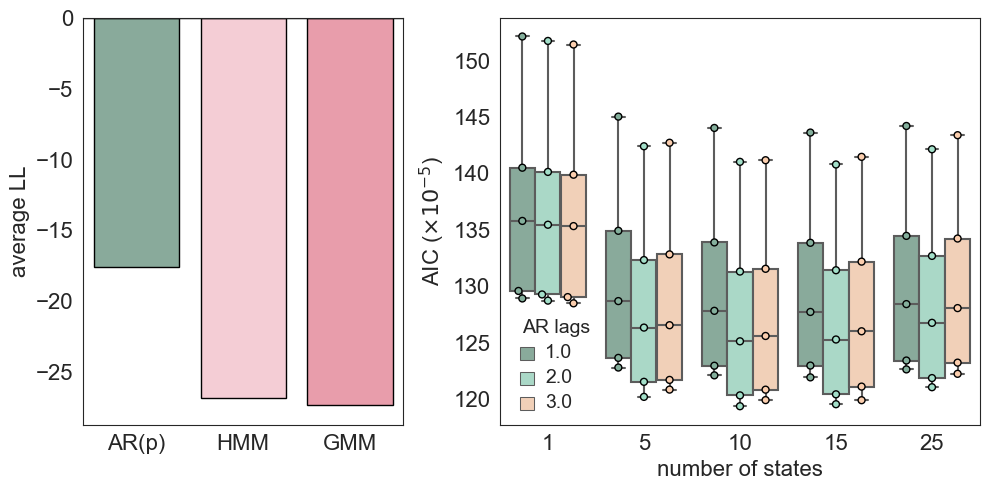

In [7]:
FONTSIZE = 16

# set legend handle size
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1

# create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10,5), width_ratios=[2, 3])

# plot the barplot on the first subplot
sns.barplot(all_results.groupby('obs_model').median(numeric_only=True).reset_index(), 
            x='obs_model', y='test_av_LL', order=['ar','gaussian','full'], 
            palette=['#84af9c','#fac7d1', '#f590a3'],
            ax=ax[0], linewidth=1, edgecolor='black')
ax[0].axhline(0, lw=1, c='black')

# plot the swarmplot and boxplot on the second subplot
sns.swarmplot(data=all_results[all_results['obs_model']=='ar'], 
                x='states', y='test_aic', hue='lag', 
                dodge=True, legend=False, 
                palette=['#84af9c','#a3dfc9','#fbceae'],
                ax=ax[1], edgecolor='black', size=5, linewidth=1) 
sns.boxplot(data=all_results[all_results['obs_model']=='ar'], 
                x='states', y='test_aic', hue='lag', 
                palette=['#84af9c','#a3dfc9','#fbceae'],
                ax=ax[1]) 

# set y-axis labels for both subplots
ax[0].set_ylabel('average LL', fontsize=FONTSIZE)
ax[1].set_ylabel(r'AIC ($\times 10^{-5}$)', fontsize=FONTSIZE)

# format y-axis labels for both subplots
ax[1].get_yticklabels()
ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.0f}'.format(x/10000)))

# set legend title and label fonts, and format legend labels
legend = ax[1].legend()
legend.set_title('AR lags')
legend.get_title().set_fontsize(FONTSIZE-2)
legend.get_title().set_position((10, 0))

for handle in legend.get_texts():
    handle.set_fontsize(FONTSIZE-2)
    #handle.set_text(str(int(float(handle.get_text()))))
legend.set_frame_on(False)

# format tick labels for both subplots
for a in ax:
    a.tick_params(axis='both', labelsize=FONTSIZE)

# set x-axis labels and ticks for both subplots
ax[0].set_xticklabels(['AR(p)', 'HMM', 'GMM'])
ax[0].set_xlabel('')
ax[1].set_xlabel('number of states', fontsize=FONTSIZE)

# adjust subplot spacing
plt.tight_layout()
plt.savefig('figures/cross_validation_model_fit.png', transparent=False, dpi=350)


### Refit on full dataset

To account for stochasticity - 25 versions of the final model were fit. For each sample, modal state estimates and median transition matrix over all 25 models were used for analysis

In [8]:
# chosen parameters
K = 15
LAG = 2
OBS = 'ar'
REG = 100

# load data
all_data = np.load('outputs/all_processed_timeseries_data.npy')
all_data = [i.T for i in all_data]
print('data shape: ', np.shape(all_data))

# quantile transform
qt.fit(np.concatenate(all_data), 0)

# scale to unit SD
data_scaled = [qt.transform(i) for i in all_data]

# fit model
full_model = ssm.HMM(K, all_data[0].shape[-1], 
                     observations=OBS, 
                     observation_kwargs={'lags':LAG, 'l2_penalty_A':REG}, 
                     transitions='sticky', transition_kwargs={'kappa': 1e8},
                     method='em')

lls = full_model.fit(data_scaled, num_iters=1000, tolerance=1e-3)

# save out
pickle.dump(full_model, open('outputs/full_model.pkl', 'wb'))

data shape:  (486, 1800, 20)


  0%|          | 0/1000 [00:00<?, ?it/s]